## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Fall 2019


# Homework 1

- **100 points [6% of your final grade]**
- **Due Wednesday, September 18 by 11:59pm**

*Goals of this homework:* There are two objectives of this homework: i) collect data from the web, clean it, and then make some observations based on exploratory data analysis; and ii) understand and implement the classic apriori algorithm to find the association rules in a movie rating dataset.

*Submission instructions:* You should post your notebook to ecampus (look for the homework 1 assignment there). Please name your submission **your-uin_hw1.ipynb**, so for example, my submission would be something like **555001234_hw1.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. 

## (10 points) Part 1a: UFOs are Out There, But First I Need to Store them Locally

For this first part, we're going to collect evidence of UFO sightings from the **National UFO Reporting Center**. Specifically, we're going to focus only on UFO sightings in Texas, as reported at this webpage:

* http://www.nuforc.org/webreports/ndxlTX.html

Recall that you can view the source of a webpage in Chrome under View &rarr; Developer &rarr; View Source. You'll notice, however, that this raw HTML is not in our friendly csv format and so will require some initial pre-processing. In particular, we're going to use the Python libraries **[requests](http://docs.python-requests.org/en/master/)** and **[beautiful soup](https://www.crummy.com/software/BeautifulSoup/)** to convert this UFO data from its original HTML format into csv. 

Hints:
* You'll notice that the column headers are in the `<TH>` tags.
* The values are in the `<TD>` tags.
* In beautiful soup, something like `.find_all('td')` may help you.
* To write the csv, you might want to `import csv` and take a look at the functions provided.
* If you google for "beautifulsoup table to csv" you should find some nice starting points.  Note, however, that you may not use an existing method that auto-magically converts the HTML into csv; we expect you to write your own code. If you borrow some elements from online resources, you should cite them in the comments. 

In [127]:
# your code here
# you should use requests to get the webpage, then extract 
# the appropriate column headings and rows
# then write this out to csv to a local file called 'ufo_texas.csv'


# import libraries

import numpy as np
import urllib.request
from bs4 import BeautifulSoup
import csv


# specify the url
urlpage =  'http://www.nuforc.org/webreports/ndxlTX.html' 
print(urlpage)

# query the website and return the html to the variable 'page'
page = urllib.request.urlopen(urlpage)

# parse the html using beautiful soup and store in variable 'soup'
soup = BeautifulSoup(page, 'html.parser')

# find results within table
table = soup.find('table')
results = table.find_all('tr')
 
i = 0 
records = []

original_count = 0

open('UFO_Original.csv', 'w').close()

with open('UFO_Original.csv', 'a+') as ufo:
    
    writer = csv.writer(ufo) 
    writer.writerow(['Date / Time', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'])
    
    # loop over results
    for result in results:

        record = []

        # find all columns per result
#         print(i)
#         i = i + 1

#         if i == 10: 
#             break

        data = result.find_all('td')

        # check that columns have data 
        if len(data) == 0: 
            continue
            
        # write columns to variables
        date_time = data[0].getText()
        City = data[1].getText()
        State = data[2].getText()    
        Shape = data[3].getText()
        Duration = data[4].getText()
        Summary = data[5].getText() 
        Posted = data[6].getText() 

        record.append(date_time)
        record.append(City)
        record.append(State)
        record.append(Shape)
        record.append(Duration)
        record.append(Summary)
        record.append(Posted)
  
        writer.writerow(record)
        original_count = original_count + 1
    
print('Total original count: ' + str(original_count))

       # records = np.row_stack((records,record)) 
    
# 參考代碼 https://github.com/kaparker/tutorials/blob/master/pythonscraper/websitescrapefasttrack.py 


http://www.nuforc.org/webreports/ndxlTX.html
Total original count: 5046


Once you have your local csv file, you should read it in and then issue the .head() command.

In [128]:
import pandas as pd

data = pd.read_csv("UFO_Original.csv")
data_2 = data.copy()
data_3 = data.copy()

data.head()
 


,Date / Time,City,State,Shape,Duration,Summary,Posted
0,9/10/19 22:10,Lake Worth,TX,Light,30 seconds,Two bright objects moving in formation.,9/12/19
1,9/6/19 21:00,League City,TX,Formation,2 minutes,As we were heading northbound on Hobbs Road in...,9/12/19
2,9/5/19 07:30,Weatherford,TX,Cylinder,30 seconds,"Re-entry moving W, W of Weatherford, TX.",9/12/19
3,9/4/19 23:00,Ozona,TX,Light,12 seconds,Light almost like a plane flying quickly above...,9/6/19
4,9/1/19 20:30,League City,TX,Circle,5 minutes,8-9 Orange glowing objects in single file line...,9/6/19


## (10 points) Part 1b: UFOs are a Mess! Time to Clean Up!

Okay, now we move to the fun part -- making sense of this messy data. These UFO reports are user-generated with little input validation. As a result, you will notice lots of oddities. 

Let's begin by focusing on the **Duration** column. As a first pass, let's make a grossly simplifying assumption -- that the only valid data is any duration that is of the form:  

* 1 second
* 2 seconds
* ...
* 1 minute
* 2 minutes
* ...
* 1 hour
* 2 hours 
* ...
* 1 day
* 2 days 
* ...

That is, we will only accept positive integers followed by a space, followed by a properly spelled unit. Every other entry is invalid. For example, that means these are all invalid durations:

* 1s
* 2 min.
* 2-3 seconds
* 10-15min
* 1 minute+
* 30 minutes and longer
* about 1.5 minutes

Create a new pandas dataframe that only includes sightings with these values, **where you convert all durations into seconds**. How many total rows are there in the original dataset? How many rows in your new 'validated' dataset? Report the basic statistics of the duration in your new 'validated' dataset (report maximum, minimum, mean, and standard deviation values of duration). At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

In [58]:
import re
 
data = data.iloc[0:]
 
open('UFO_Filtered.csv', 'w').close()

count_filtered = 0 

with open('UFO_Filtered.csv', 'a+') as ufo:

    writer = csv.writer(ufo) 
    writer.writerow(['Date / Time', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'])
    
    time_pattern = {'minutes','minute', 'hours', 'hour', 'seconds','second'}
    
    for index, row in data.iterrows():
 
        # Check if null or empty
        if row[4] is None: 
            continue 
    
        # Convert to String
        str_1 = str(row[4])
        
        # Print str_1
        # print(str_1)
        
        pattern = re.split('\s+', str_1)
        
        if (len(pattern) != 2):
            continue
          
        p_1 = pattern[0]
        p_2 = pattern[1]

        flag_remove = False
 
        if p_1.isdigit() is not True:
            flag_remove = True

        if p_2 not in time_pattern: 
            flag_remove = True
 
            
        if flag_remove is False: 
        
            t = 0 
            if p_2 in ('minutes', 'minute'): 
                t = 60*int(p_1)
            elif p_2 in ('hours', 'hour'): 
                t = 3600*int(p_1)
            else: t = p_1 
            
            row[4] = t
            
            writer.writerow(row)
            count_filtered = count_filtered + 1
            
print('Total count after filter: ' + str(count_filtered))
    
# filter our invalid durations
# convert all valid durations to seconds

 

# How many total rows are there in the original dataset? 
# How many rows in your new 'validated' dataset? 
# Report the basic statistics of the duration in your new 'validated' dataset 
# (report maximum, minimum, mean, and standard deviation values of duration). 
# At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.



30 seconds
2 minutes
30 seconds
12 seconds
5 minutes
3-5 minutes
15 minutes
:30
7 seconds
instantaneous
10 seconds
09:55
30 seconds
20 minutes
Unknown
3 hours
20 minutes
1 minute
:50
1 second
1 second
25 seconds
:25
10-15 seconds
Unknown
nan
<1 minute
10 seconds
1 second
3 minutes
20 seconds
Few minutes
00:05
2 seconds
10 minute
1 minute
30 seconds
10 minutes
10 seconds
5 min.
10 minutes
20:47
1 minute
nan
10 seconds
45 seconds
10 minutes
~5 minutes
1 minute
3 minutes
6 minutes
5 minutes
nan
15 minutes
20 minutes
1 minute
1 hour
1 hour & 41 minutes
45
1 minute
4
15 minutes
nan
10 seconds
2 minutes
10 seconds
2 minutes
5 seconds
30 seconds
~1 hour
~15 seconds
10 minutes
15 minutes
3 seconds
3 minutes
20 seconds
<60 seconds
35 seconds
1 minute or less
1:00 minute
7 minutes
4 minutes
15 seconds
5 seconds
10 minutes
20 minutes
nan
1 minute
1 minute
2 minutes
5 minutes
15 minutes
2 minutes
5-7 seconds
30 seconds
30 seconds
5 minutes
2 minutes
<4 minutes
5 minutes
20 minutes
1 hour
All Night

5 minutes
2 minutes
3 minutes
15 minutes
30 seconds
nan
2-3 minutes
5 seconds
10 minutes
5 minutes
12 minutes
45-90 minutes
15 minutes
1-2 minutes
10 minutes
5 minutes
couple minutes
2 minutes
2-3 minutes
1+ hour
5 minutes
3 minutes
20 seconds (each)
10
20 seconds
2 minutes
10 minutes
5 minutes
15 seconds
15 minutes
20-30 minutes
working/driving
30 minutes
30 minutes
10 seconds
3-5 minutes
3 seconds
5-10 seconds
5-8 minutes
nan
1 hour
30 minutes
5 minutes
5 minutes
1-2 minutes
1 hour
10-15 seconds
<15 seconds
3 minutes
3 minutes
10 seconds
30-45 seconds
6 seconds?
10 minutes
10 seconds
<1 minute
3 minutes
5-7 minutes
10 minutes
20 seconds
20 minutes
5-7 minutes
10 minutes
25 minutes
night
45 seconds
10
5 minutes
2 minutes
2 seconds
nan
seconds
7 seconds
1 minute
10 minutes
nan
13 seconds
few minutes
5 minutes
5-6 seconds
10 seconds
10 minutes
Night sky
20-30 minutes
1/30th second
4 minutes
1.5 seconds
1 minute
45-60 seconds
8:15-9:03
1-2 minutes
2-3 minutes
15 seconds
10 minutes
hour
3

2 minutes
30 minutes
3 min
20-25 seconds
several minutes
3 minutes
about 5 minutes
5 min
all day - still going on
1 minute
10 Seconds
1 minute
45 seconds repeatedly
5 minutes
5 minutes
5 minutes
2 and a half  minutes
1 second
nan
10 minutes
18 mins
30 seconds
30 mins
1 hour +
30 sec
Hour and a half
nan
2hr
2 minutes
20 minutes
2 seconds
1 minute
15 Seconds
5 mins
30 min
1 minnute
5 to 10 minutes
3 seconds
2 min.
10 min
3 min
1-2 hours
3minutes
all night
1-2 minutes
30 sec
30 seconds
30 min.
30 sec.
5-10 minutes
10-20 minutes
10 seconds
30 minutes
5 min
5 SECONDS
2-3 seconds
15 secs
3 minutes
2-3 seconds
5 minutes
nan
1 MIN
2 seconds
seconds
00:03
1 hour
30 + min
1.00 minute
10 minutes
30 minutes
15 -20 seconds
about 20 min
20 seconds
45 minutes
10 seconds
3 min.
11-12 seconds
5 min
nan
nan
less then a minute
30 sec -1min
40 minutes
30 min
34 sec
15 min approx
1 minute
1-2 min
1 1/2 min.
nan
6 seconds
5 secs
13 minutes
1 min
5 Hours
1 hour 15 min
15 minutes
5 seconds
3 min
10
30 minutes

few seconds
5-7 Seconds
15-20 minutes
6 min
45 minutes
15 minutes
30 minutes
15 minutes+
sky
20 sec
2 minutes
Photo Shot
ONLY ONE
15seconds
10 minutes
30 min
4 hours
7 minutes
all night
10 minutes
4+ minutes
10 minutes
15 Minutes
8 minutes
2 min
30 seconds
1 minute
15 minutes
Hours
40sec.
5 minutes
2 minutes
8 MINUTES
5 minutes
7 minutes
15 Seconds
2 hours
2 - 3 minutes
continus
10 min
5 SECONDS
1.5 hours
15 minutes
4 minutes
3 min
10-15 sec
20-25 minutes
2hrs/1mo.
2 min
3mins
1 minute
2 or 3 Seconds
still going on
24:00
24:00
nan
5 minutes
5 minuts
20 seconds
2MINUTES
2 hours
Around one minute
4 seconds
1.5 hours
5 minutes
1 minute
5 minutes
2 hours
About 15 seconds
30min
13 minutes
2 Min
1-3 seconds
1-2 seconds
3 to 5 minutes
45 mins
10 min.
3 minutes
30 minutes
4 min
3 seconds
10 minutes
5 minutes
3-5 seconds
30 secs
30 Seconds
30 seconds
30 sec.
10 minutes
less than 15mins
nan
20 seconds
15 sec
3-5 minutes
10 min
not sure
2-3 minutes
2 seconds
1 minute
10 seconds
a few seconds
a fe

1 1/2 hrs.
1-1.5 seconds
20 sec
5 seconds max
15 to 20 minutes
seconds
40 seconds
4 minutes
5 seconds
5 Minutes
all day
3-4 seconds
5 seconds
25 seconds
few seconds
5 seconds
less than 1 minute
30 minutes
5 seconds
8 seconds
2 sec.
2 hrs
in a car
nan
5 minutes
20 MIN.
west
00:15
45 sec
30 seconds
45 sec
1.5 min
hours
few minutes
3 seconds
3 Minutes
approx 10sec
4-5 minutes
UNK
10 minutes
10 min.
3 minutes
2 seconds
10MIN
1minute
5 minutes
4 minutes
8 minutes
10 seconds
3 seconds
10 seconds
4 mins
nan
0:02
quick fly by
5-10 seconds
12 Sec.
4 seconds
01-01.5 minutes
30 mins
20 sec.
15 Sec.
18:01
2 minutes
3 SECONDS
5 minutes
8 sec+-
1 minute
5 minutes
10 seconds
30 seconds
2 minutes
1 minute
10 minutes
APPROX 3 SECONDS
2 Min.
2330
30 seconds
?
45 seconds
within a 15 sec. span
2 SEC
30 sec.
1 hour
15 seconds
Two min.
2 mins
more than  30 min
ongoing
30 minutes
10 sec
5 seconds
10 sec
20 minutes
1-2 minutes
2 min
5 minutes
aprox. 8 seconds
15-20 min
3 seconds
5 min
4 seconds
10-15 minutes


In [59]:
# your code here
print('Total original countd: ' + str(original_count))
print('Total count after filter: ' + str(count_filtered))

Total original countd: 5046
Total count after filter: 2461


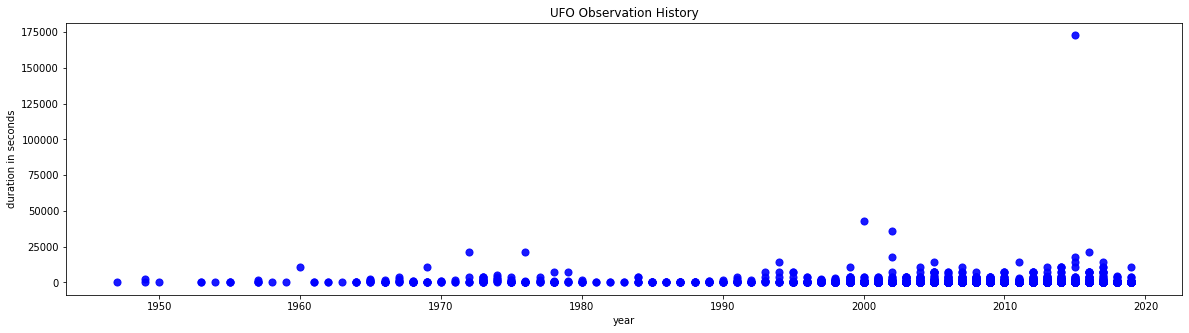

In [174]:
# your code here
# report the basic statistics of duration in 'validated' dataset
# boxplot code here
# Report the basic statistics of the duration in your new 'validated' dataset 
# (report maximum, minimum, mean, and standard deviation values of duration). 
# At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

data = pd.read_csv("UFO_Filtered.csv")
data.head()
data.describe()

import matplotlib.pyplot as plt
import datetime
                                                                                                                
x = data.loc[ : , 'Date / Time']
y = data.loc[ : , 'Duration']
    
k = 0 

x_final= [] 
y_final = []


# loop every time point in x
for i in x: 
    
    i_i = str(i)
    
    # ignore the empty date
    if i_i == 'nan': 
        k = k + 1
        continue
    
    pattern = re.split('\s+', i_i)
    
    i_i = pattern[0]
 
    m_d_y = re.findall(r'[^\\/]+|[\\/]', i_i)
     
    minute = int(m_d_y[0])
    day = int(m_d_y[2])        
    year = int(m_d_y[4])

    # convert the year to correct format
    if year < 20: 
        year = year + 2000
    elif year > 1000: 
        year = year
    elif year < 100: 
        year = 1900 + year 
   
    # update new x and y 
    x_final.append(year)       
    y_final.append(y[k])       
    
    k = k + 1
    
# fig = plt.figure(figsize=(20, 2))
# ax = fig.add_subplot(111)
# ax.plot(x_final,y_final)    

 
area = np.pi*3

plt.figure(figsize=(20, 5))
plt.scatter(x_final, y_final, s=50, c='blue', marker = 'o', alpha=0.9)
plt.title('UFO Observation History')
plt.xlabel('year')
plt.ylabel('duration in seconds')
plt.show()


## (30 points) Part 1c: Can we do better?
Interesting. But we threw away a **lot** of data. We can do better. For this part, you will do your best to clean up the durations from your original dataset. Keep in mind some initial guidelines:

* If a duration has a range, use the average as its value. For example, if the duration is listed as “6-8 minutes”, you should consider the duration as “7 minutes”. (Again, you will need to eventually convert minutes into seconds).
* If a duration has a “<” sign, you should simply ignore the “<” sign. For example if the duration is specified as “< 1 minute”, consider the duration to be “1 minute”. You should subsequently convert “1 minute” to "60 seconds".
* If a duration has a “>” sign, you should simply ignore the “>” sign. 
* You should ignore any row with an empty duration.

You will probably have to improvise as you go along, so **make detailed notes of what decisions you are making and why**.

In [350]:
import re

data_2 = data_2.iloc[0:]  # delete the 1st row
 
count_refine_filtered = 0 
 
data_test = data_2.copy()
    
open('UFO_Further_Clean.csv', 'w').close()

with open('UFO_Further_Clean.csv', 'a+') as ufo:
    
    writer = csv.writer(ufo) 
    writer.writerow(['Date / Time', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'])
    
    time_pattern = {'MIN','HOU','HR','SEC'}
 
    # 迭代 data_2
    for index, row in data_test.iterrows():
 
        if row[4] is None: 
            continue 
    
        # Convert for duration
        str_1 = str(row[4])
        # print(str_1)
   
        # Split the "Duration" string
        pattern = re.split('\s+', str_1)
    
        # Get the numbers 
        p_1 = pattern[0]
    
        if len(pattern) < 2: continue
            
        # Get the definitions     
        p_2 = pattern[1]
 
        # get all the numbers in the p_2
        p_1_list = re.findall(r"\d+\.?\d*",p_1)
        
        # Confirm the time number
        t_final = 0 
        
        # Calculate the duration numbers
        if len(p_1_list) > 2 or len(p_1_list) == 1: 
            t_final = float(p_1_list[0])
        elif len(p_1_list) == 2:
            t_final = float(p_1_list[1]) - float(p_1_list[0])
        
        # Give a flag 
        flag_remove = False
  
        if flag_remove is False: 
 
            t_total = 0 
            if p_2 == ('MIN'): 
                t_total = 60*t_final
            elif p_2 in ('HOU', 'HR'): 
                t_total = 3600*t_final
            else: t_total = t_final
            
            row[4] = t_total
            
            writer.writerow(row)
            
            count_refine_filtered += 1
            
print('Total count after filter: ' + str(count_refine_filtered))
    
# filter our invalid durations
# convert all valid durations to seconds

# How many total rows are there in the original dataset? 
# How many rows in your new 'validated' dataset? 
# Report the basic statistics of the duration in your new 'validated' dataset 
# (report maximum, minimum, mean, and standard deviation values of duration). 
# At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.





Total count after filter: 4387


In [351]:
print(   'Total original countd: ' + str(original_count)   )  
print(   'Total count after count_refine_filtered: ' + str(count_refine_filtered)   )  

Total original countd: 5046
Total count after count_refine_filtered: 4387


77777777
77777777
77777777
77777777


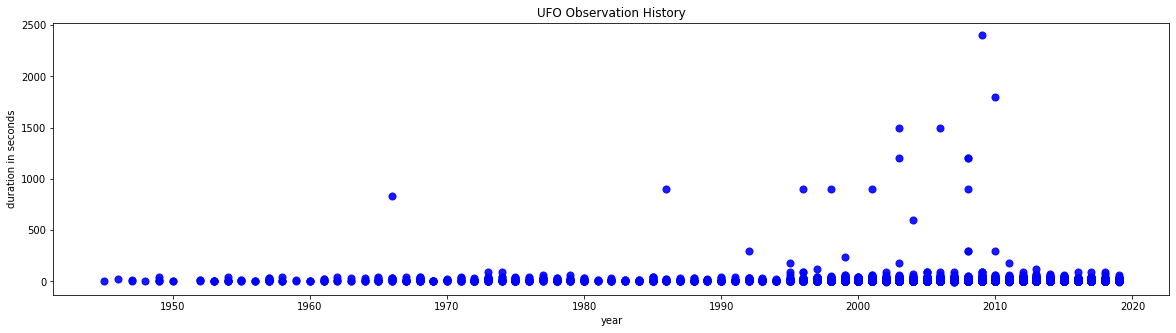

In [367]:
data_test = pd.read_csv("UFO_Further_Clean.csv")

# report the basic statistics of duration in your cleaned dataset
data_test.describe()


# draw a boxplot for your cleaned dataset
import matplotlib.pyplot as plt
import datetime
    
x = data_test.loc[ : , 'Date / Time']
y = data_test.loc[ : , 'Duration']
    
k = 0 

x_final= [] 
y_final = []


# loop every time point in x
for i in x: 
    
    i_i = str(i)
    
    if i_i == 'nan': 
        k = k + 1
        continue
        
    backslash_flag = True    
    
    if '/' not in i_i: 
        print('77777777')
        continue 
 
    pattern = re.split('\s+', i_i)
    
    i_i = pattern[0]

    m_d_y = re.findall(r'[^\\/]+|[\\/]', i_i)
  
    minute = int(m_d_y[0])
    day = int(m_d_y[2])        
    year = int(m_d_y[4])

    # convert the year to correct format
    if year < 20: 
        year = year + 2000
    elif year > 1000: 
        year = year
    elif year < 100: 
        year = 1900 + year 
    
    # print(y) 
    
    # update new x and y 
    x_final.append(year)       
    y_final.append(y[k])       
    
    k = k + 1
    
# fig = plt.figure(figsize=(20, 2))
# ax = fig.add_subplot(111)
# ax.plot(x_final,y_final)    
 
area = np.pi*3

plt.figure(figsize=(20, 5))
plt.scatter(x_final, y_final, s=50, c='blue', marker = 'o', alpha=0.9)
plt.title('UFO Observation History')
plt.xlabel('year')
plt.ylabel('duration in seconds')
plt.show()

Now, introduce your cleaning process step by step and explaine the reason behind your steps. Then, revisit your two boxplots -- for the initial "valid" dataset and then for your cleaned dataset. What do you observe? What differences does cleaning have? Would you imagine your downstream analyses would be affected by this cleaning step? Explain.

`Discussion: Add your discussion here`

## (10 points) Part 1d: Probe This, you Alien Invaders.
Finally, let's begin our initial analysis of the cleaned UFO dataset. In this section, we're going to do some plotting with matplotlib and draw some initial conclusions that may guide our future study of this UFO dataset. 

Question 1: Which **shapes** are most observed?

array('i', [896, 136, 77, 398, 328, 344, 244, 279, 246, 70, 458, 113, 38, 128, 98, 264, 45, 71, 11, 62, 65, 15, 1])
['LIGHT', 'FORMATION', 'CYLINDER', 'CIRCLE', 'UNKNOWN', 'OTHER', 'OVAL', 'SPHERE', 'FIREBALL', 'NAN', 'TRIANGLE', 'CHANGING', 'EGG', 'CIGAR', 'RECTANGLE', 'DISK', 'TEARDROP', 'FLASH', 'CROSS', 'CHEVRON', 'DIAMOND', 'CONE', 'DELTA']
array('i', [14388, 1470, 1191, 4013, 3678, 4297, 3399, 4814, 2321, 974, 6957, 4211, 397, 3239, 1966, 2442, 386, 1332, 57, 802, 670, 160, 2])


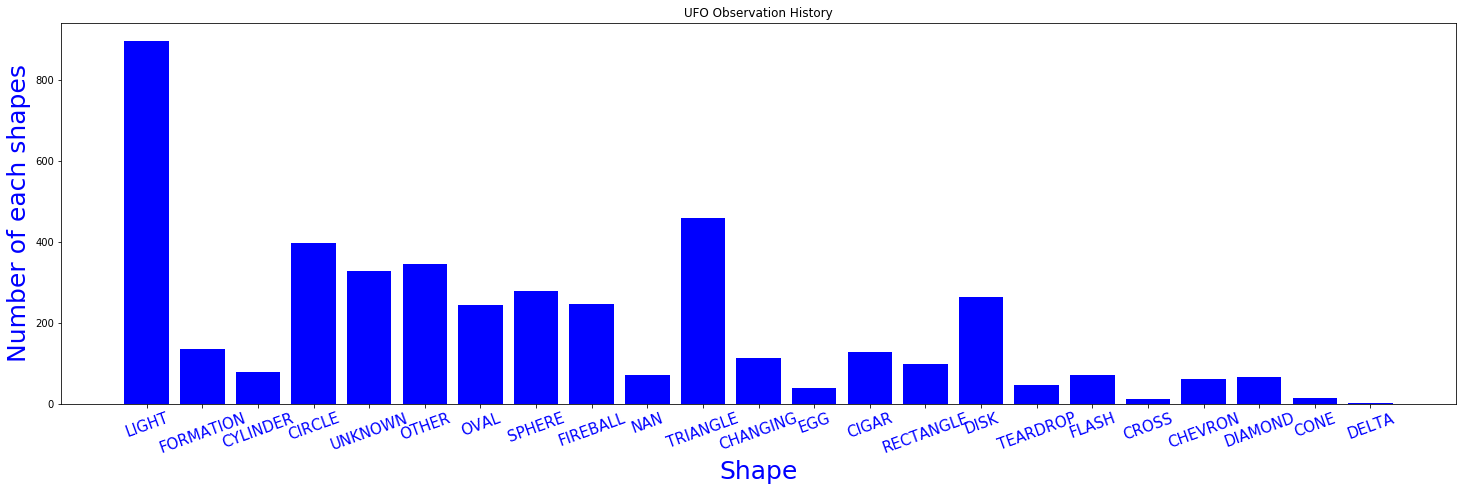

Text(0.5, 1.0, 'Pie chart')

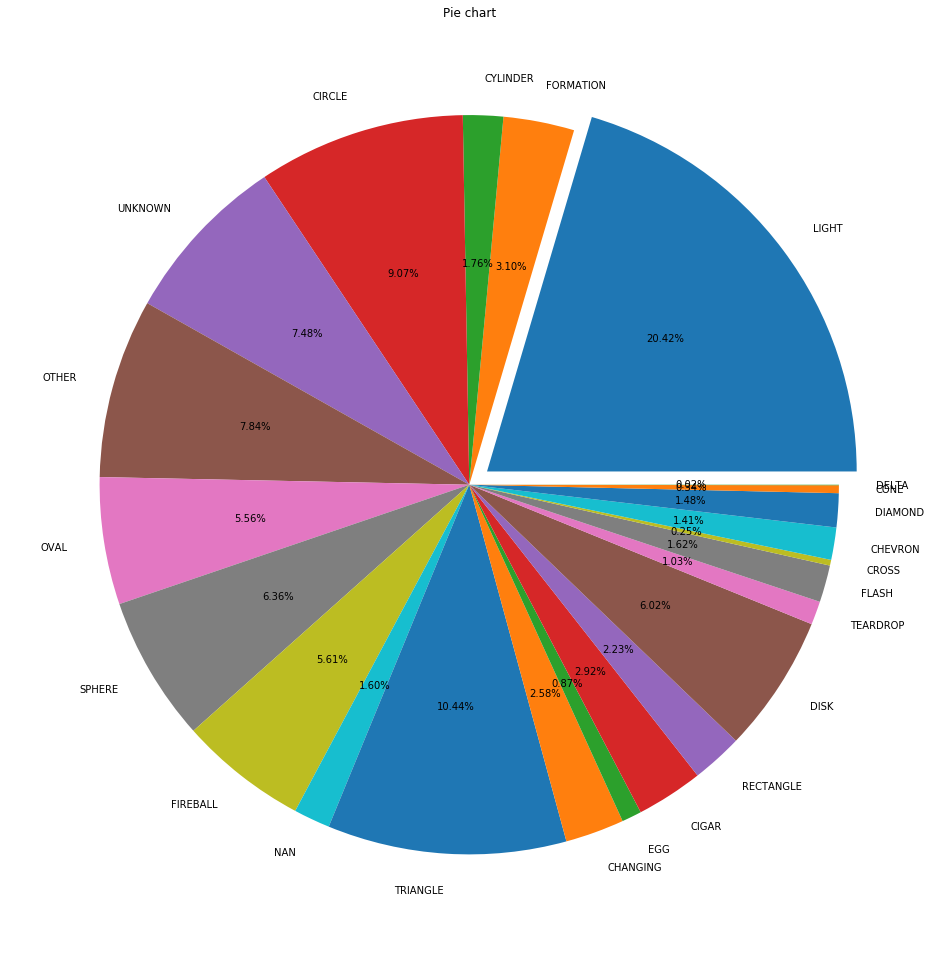

In [363]:
import array

# your code here
data_test = pd.read_csv("UFO_Further_Clean.csv")

data_test.describe()

y = data_test.loc[ : , 'Shape']
Duration = data_test.loc[ : , 'Duration']

 
collection = [] 

# Collect all the shapes
for i in y: 
    i = str(i)
    if i.upper() not in collection: 
        collection.append(i.upper())

collection_idx = array.array('i',(0 for i in range(0,(len(collection)))))
collection_duration = array.array('i',(0 for i in range(0,(len(collection)))))
collection_duration_average = array.array('i',(0 for i in range(0,(len(collection)))))
    
# check for every shape in y    
idx_for_duration = 0
for i in y:
    i = str(i)
    
    # Check for all shapes
    idx = 0
    for j in collection: 
        if j == i.upper():
            # update shape count
            collection_idx[idx] += 1
            # update duration summary
            collection_duration[idx] += int(Duration[idx_for_duration])
        idx += 1
 
    idx_for_duration += 1    
            
print(collection_idx)       
print(collection)
print(collection_duration)

plt.figure(figsize=(25, 7)) 
plt.bar(collection, collection_idx, color = 'blue')

plt.title('UFO Observation History')
plt.xlabel('Shape', size="25", color='blue')
 
plt.xticks(rotation=20, size="15", color='blue')

plt.ylabel('Number of each shapes',size="25",color='blue')
plt.show()    

explode = (0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) 

plt.figure(figsize=(40, 17)) 
plt.pie(collection_idx,labels=collection,autopct='%1.2f%%',explode=explode) #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Pie chart")

# create a plot of shapes (your choice of what you consider the appropriate plot)

Question 2: Do different UFO shapes have different durations?

array('i', [14388, 1470, 1191, 4013, 3678, 4297, 3399, 4814, 2321, 974, 6957, 4211, 397, 3239, 1966, 2442, 386, 1332, 57, 802, 670, 160, 2])
array('i', [896, 136, 77, 398, 328, 344, 244, 279, 246, 70, 458, 113, 38, 128, 98, 264, 45, 71, 11, 62, 65, 15, 1])
array('i', [16, 10, 15, 10, 11, 12, 13, 17, 9, 13, 15, 37, 10, 25, 20, 9, 8, 18, 5, 12, 10, 10, 2])


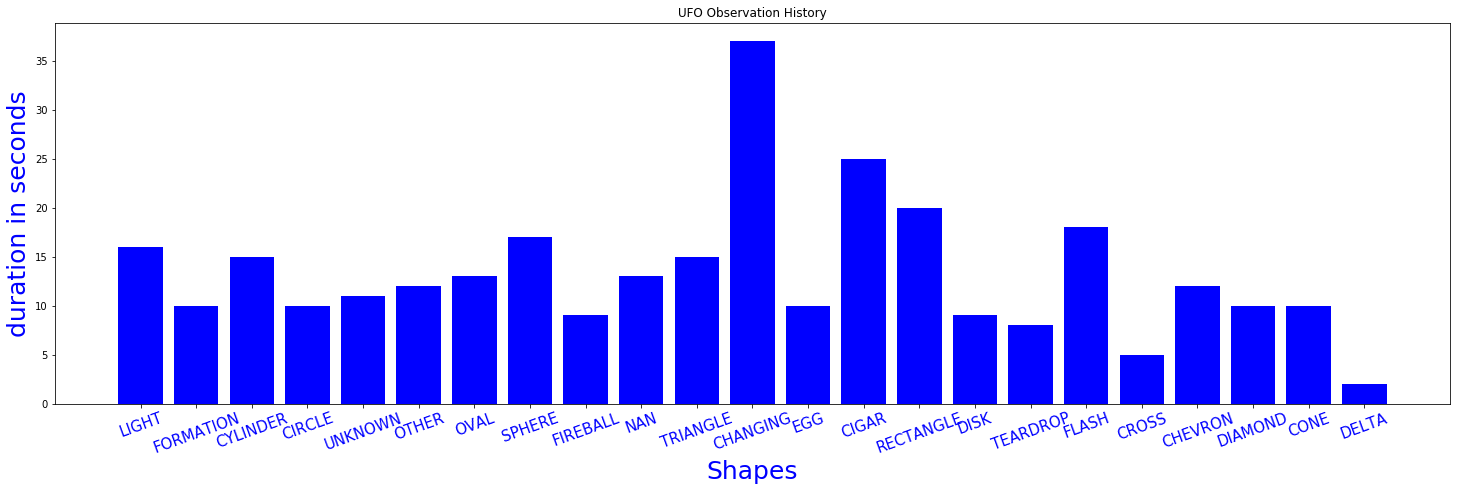

Text(0.5, 1.0, 'Pie chart')

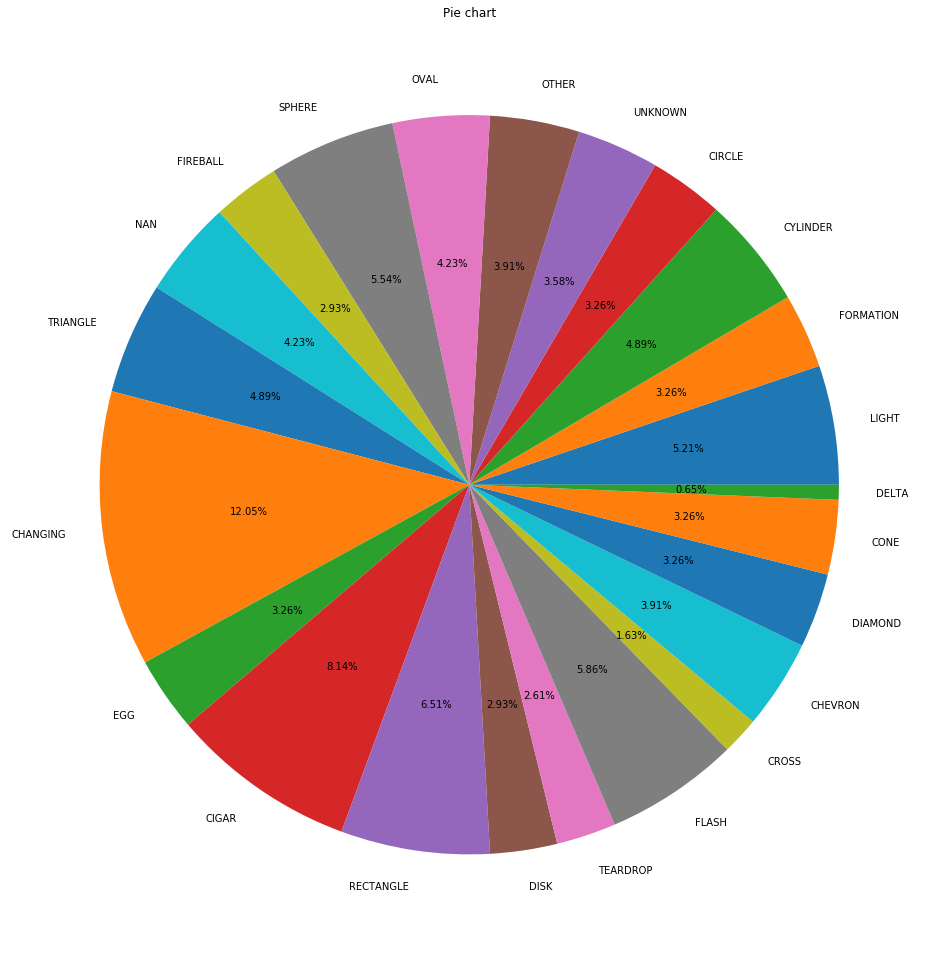

In [365]:
# Calculate average time for each shape
 
c_idx = 0
for i in collection_idx: 
    collection_duration_average[c_idx] = int(collection_duration[c_idx]/collection_idx[c_idx])
    c_idx += 1
    
print(collection_duration)    
print(collection_idx)
print(collection_duration_average)

# create a plot of shapes/durations

plt.figure(figsize=(25, 7)) 
plt.bar(collection, collection_duration_average, color = 'blue')
plt.title('UFO Observation History')
plt.xlabel('Shapes', size="25", color='blue')

plt.xticks(rotation=20, size="15", color='blue')
plt.ylabel('duration in seconds',size="25",color='blue')
plt.show()    

plt.figure(figsize=(40, 17)) 
plt.pie(collection_duration_average,labels=collection,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Pie chart")

Question 3: Are there more UFO sightings in recent years than in the past?

77777777
77777777
77777777
77777777


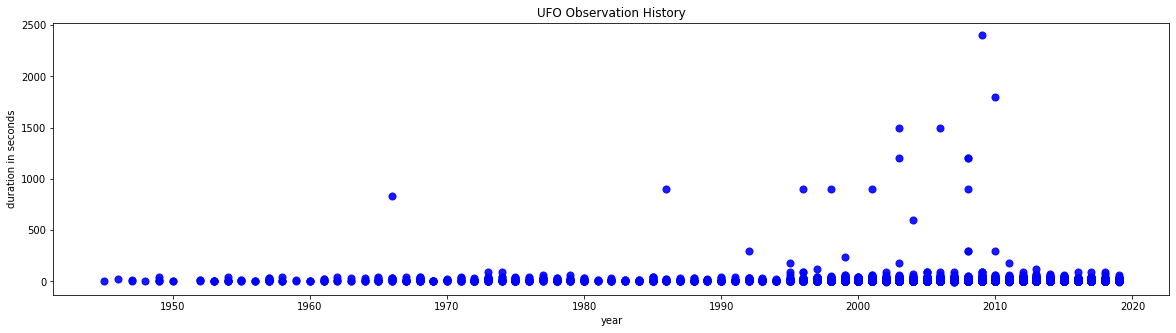

In [366]:
data_test = pd.read_csv("UFO_Further_Clean.csv")

# report the basic statistics of duration in your cleaned dataset
data_test.describe()


# draw a boxplot for your cleaned dataset
import matplotlib.pyplot as plt
import datetime
    
x = data_test.loc[ : , 'Date / Time']
y = data_test.loc[ : , 'Duration']
    
k = 0 

x_final= [] 
y_final = []


# loop every time point in x
for i in x: 
    
    i_i = str(i)
    
    if i_i == 'nan': 
        k = k + 1
        continue
        
    backslash_flag = True    
    
    if '/' not in i_i: 
        print('77777777')
        continue 
 
    pattern = re.split('\s+', i_i)
    
    i_i = pattern[0]

    m_d_y = re.findall(r'[^\\/]+|[\\/]', i_i)
  
    minute = int(m_d_y[0])
    day = int(m_d_y[2])        
    year = int(m_d_y[4])

    # convert the year to correct format
    if year < 20: 
        year = year + 2000
    elif year > 1000: 
        year = year
    elif year < 100: 
        year = 1900 + year 
    
    # print(y) 
    
    # update new x and y 
    x_final.append(year)       
    y_final.append(y[k])       
    
    k = k + 1
    
# fig = plt.figure(figsize=(20, 2))
# ax = fig.add_subplot(111)
# ax.plot(x_final,y_final)    
 
area = np.pi*3

plt.figure(figsize=(20, 5))
plt.scatter(x_final, y_final, s=50, c='blue', marker = 'o', alpha=0.9)
plt.title('UFO Observation History')
plt.xlabel('year')
plt.ylabel('duration in seconds')
plt.show()

Question 4: Based on your observations and analyses, what are some important next steps we should take?

1. It seems that there are more UFOs that stays longer time in our observations in recent years. We should collect those related video and make further research.
2. Are there more specific objects that emerges in recenlty years? It's better to find out which ones are more common and we can further location their place and possible time - morning or night. 
3. We should collect more UFO observations in other stays. 
4. What seasons will the UFO showup often? 
5. Which UFOs normally showing up moving or statically. What shapes they are.

## (40 points) Part 2: Association Rules in Movie Rating Behaviors
In this part, we are going to leave the study of UFOs behind us. Now we are going to examine movies using our understanding of association rules. For this part, you need to implement the apriori algorithm, and apply it to a movie rating dataset to find association rules of user movie rating behaviors. First, run the next cell to load the dataset we are going to use.

In [368]:
# First load the dataset
import pandas as pd
movie_rating_df = pd.read_csv('./movie_rated.csv')
movie_rating_df.head()

,userId,movieId
0,1,2160
1,1,2312
2,1,144
3,1,480
4,2,2160


In this dataset, there are two columns: userId is the integer ids of users, and movieId is the integer ids of movies. Each row denotes that the user of given userId rated the movie of the given movieId. We are going to treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket. 

Now, you need to implement the apriori algorithm and apply it to this dataset to find association rules of user rating behaviors with **minimum support of 0.2** and **minimum confidence of 0.8**. We know there are many existing implementations of apriori online (check github for some good starting points). You are welcome to read existing codebases and let that inform your approach. Do not copy-paste any existing code. We want your code to have sufficient comments to explain your steps, to show us that you really know what you are doing. Furthermore, you should add print statements to print out the intermediate steps of your method -- e.g., the size of the candidate set at each step of the method, the size of the filtered set, and any other important information you think will highlight the method. 

In [370]:
movie_rating_df.describe()

# your code here, including all the helpful print statements

Sorry, I have 


# when you run this block, we want to see all of your intermediate steps
# you can save the rules you discover for printing in the following cells (this will help us grade by
# keeping these separate)

,userId,movieId
count,11743.000000,11743.000000
mean,242.086179,1598.796304
std,141.595115,906.117586
min,1.000000,5.000000
25%,116.000000,994.000000
50%,255.000000,1556.000000
75%,351.000000,2309.500000
max,494.000000,3274.000000


Finally, print your final association rules in the following format:

**movie_name_1, movie_name_2, ... --> movie_name_k**

where the movie names can be fetched by joining the movieId with the file 'movies.dat'. For example, one rule that you should find is:

**Jurassic Park (1993), Back to the Future (1985) --> Star Wars: Episode IV - A New Hope (1977)**


In [ ]:
# just the rules

## (5 points) BONUS

Finally, we'll set aside a few bonus points (like 1-5) for any improvement for the apriori algorithm, such as the SON algorithm or Toivonen’s algorithm. Specify the algorithm you are implementing, apply it to the same dataset we used above and report the results, and discuss how this algorithm is different from the conventional apriori algorithm.

In [ ]:
# your code here